In [1]:
import os
import sys
import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

sys.path.insert(0, os.path.abspath("../"))
from tqdm import tqdm
from tensorflow import data
import tensorflow
from ImageDataset import NatPatchDataset, load_data
from utils import parse_args
from plotting import plot_rf
from imp import reload

In [2]:
gpu = tf.config.experimental.get_visible_devices("GPU")[0]
tf.config.experimental.set_memory_growth(gpu, enable=True)
tb_path = "../output/m1"
class test():
    batch_size = 2000
    n_neuron = 400
    size = 10
    epoch = 100
    learning_rate = 1e-2
    r_learning_rate = 1e-2
    reg = 0.01
arg = test()

In [3]:
dataloader = tf.data.Dataset.from_tensor_slices(load_data(arg.batch_size, arg.size, arg.size))
print('loading data finished')

loading data finished


In [4]:
num = tf.data.experimental.cardinality(dataloader).numpy()
num+1

20001

In [11]:
import Sparse
reload(Sparse)
tf.autograph.set_verbosity(0)
from Sparse import SparseNet
class test():
    batch_size = 2000
    n_neuron = 400
    size = 10
    epoch = 100
    learning_rate = 1e-2
    r_learning_rate = 5e-3
    reg = 5e-3
arg = test()
batch_size = 20000
optimizer1 = tf.keras.optimizers.SGD(learning_rate=1e-1)
sparse_net = SparseNet(K=arg.n_neuron, M=arg.size, R_lr=arg.r_learning_rate, lmda=arg.reg, optimizer=optimizer1)
sparse_net.build(input_shape=(batch_size,))
num = tf.data.experimental.cardinality(dataloader).numpy()
optimizer2 = tf.keras.optimizers.SGD(learning_rate=1e-3)
print("model build finished")
min_loss = tf.Variable(float('inf'), dtype = tf.float32)
cur_iter = tf.Variable(0, dtype = tf.int32)
old_loss = tf.Variable(0, dtype = tf.float32)
converged = tf.Variable(False, dtype = tf.bool)
for e in range(40):
    _ = dataloader.shuffle(num, reshuffle_each_iteration = True)
    # while not converged:
    running_loss = 0
    for img_batch in dataloader.batch(batch_size):
        img_batch = tf.reshape(img_batch, (img_batch.shape[0], -1))
        with tf.GradientTape() as tape:
            tape.watch(sparse_net.U.weights[0])
            pred = sparse_net(img_batch, training= True)
            loss = tf.math.reduce_sum(tf.square(img_batch - pred))
        running_loss += loss
        gradients = tape.gradient(loss, sparse_net.U.weights[0])
        _ = optimizer2.apply_gradients([(gradients, sparse_net.U.weights[0])])
    _ = sparse_net.normalize_weights()
    if e % 1 == 0:
        persever_loss = running_loss.numpy()
        sparse_loss = tf.math.reduce_sum(tf.math.abs(sparse_net.R)).numpy()
        total_loss = persever_loss + sparse_loss
        nonzero_number = tf.math.count_nonzero(sparse_net.R).numpy()
        max_val = tf.math.reduce_max(sparse_net.weights[0])
        weight = tf.abs(sparse_net.weights[0])
        geq_zero = tf.where(weight >0 , weight, float('inf'))
        min_val = tf.math.reduce_min(geq_zero)
        print('Iter: {},Total loss: {:.2f}, persever loss: {:.2f}, sparse loss: {:.2f}, nonzero number {}, max val:{:.2f}, min val:{:.9f}'.format(e, total_loss, persever_loss, sparse_loss, nonzero_number, max_val, min_val))
print("finished.")  # sparse_net = NatPatchDataset(arg.n_neuron, arg.size, R_lr = arg.r_learning_rate, lmda = arg.reg)

<module 'Sparse' from '/media/cdyk/my_files/kaggle/visual_vgg/sparse_code/src/Sparse.py'>

model build finished
Iter: 0,Total loss: 125929.95, persever loss: 84941.77, sparse loss: 40988.19, nonzero number 253336, max val:0.23, min val:0.000000786
Iter: 1,Total loss: 113556.09, persever loss: 65696.95, sparse loss: 47859.14, nonzero number 281143, max val:0.26, min val:0.000006225
Iter: 2,Total loss: 106239.08, persever loss: 57133.21, sparse loss: 49105.86, nonzero number 275687, max val:0.28, min val:0.000002318
Iter: 3,Total loss: 102145.85, persever loss: 52898.38, sparse loss: 49247.47, nonzero number 265320, max val:0.29, min val:0.000001835
Iter: 4,Total loss: 99582.23, persever loss: 50365.90, sparse loss: 49216.34, nonzero number 256640, max val:0.31, min val:0.000001978
Iter: 5,Total loss: 97793.45, persever loss: 48644.32, sparse loss: 49149.14, nonzero number 249737, max val:0.33, min val:0.000001944
Iter: 6,Total loss: 96456.30, persever loss: 47367.89, sparse loss: 49088.40, nonzero number 244431, max val:0.33, min val:0.000001590
Iter: 7,Total loss: 95406.80, 

In [ ]:
tf.math.count_nonzero(sparse_net.R)

<module 'plotting' from '/media/cdyk/my_files/kaggle/visual_vgg/sparse_code/src/plotting.py'>

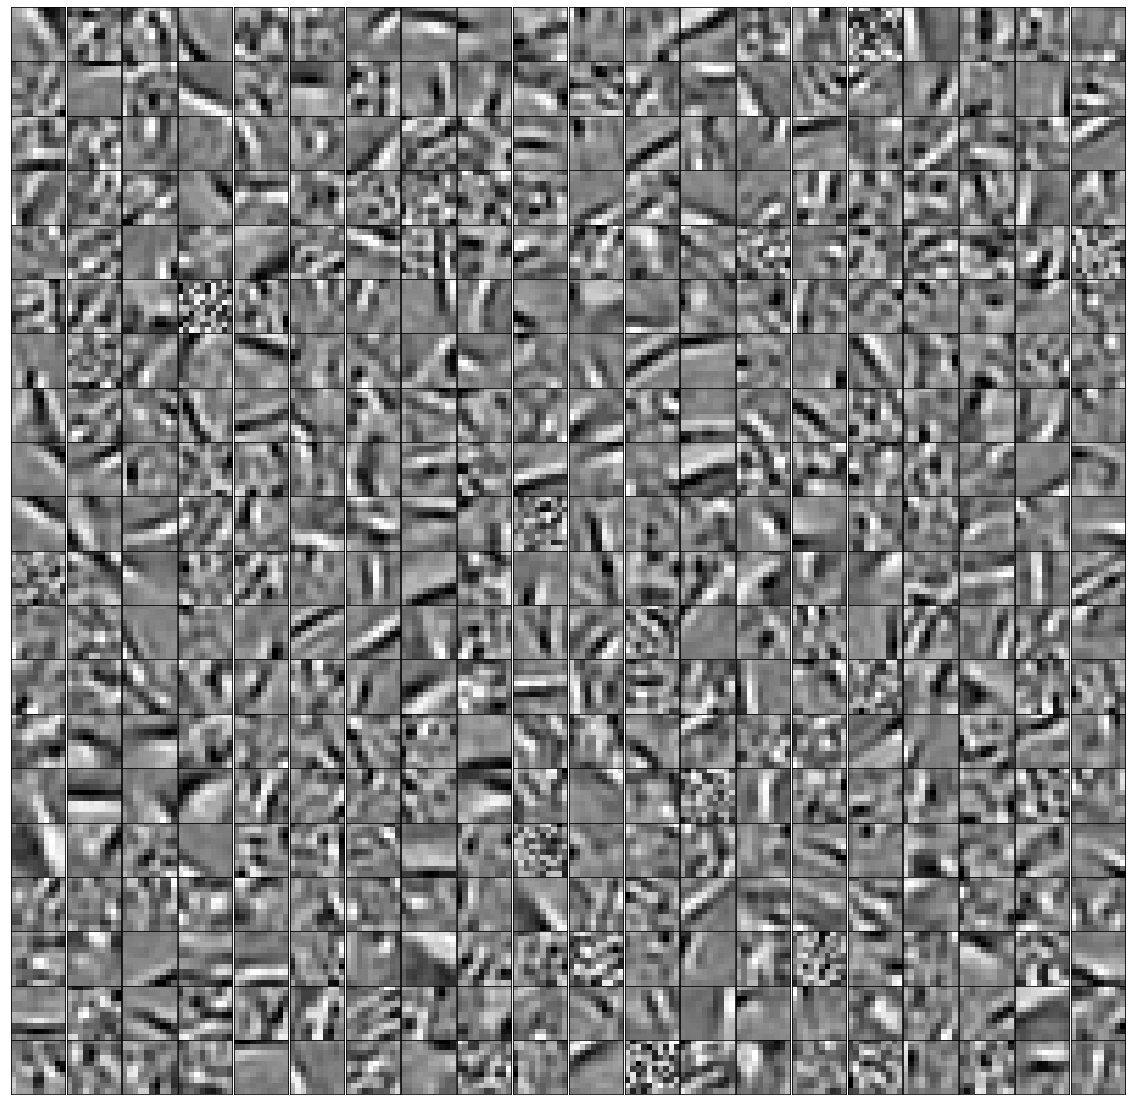

In [13]:
import plotting
reload(plotting)
from plotting import plot_rf
weight = sparse_net.U.weights[0]
# weight = tf.transpose(weight)
weight = weight.numpy()
_ = plot_rf(weight, arg.n_neuron, arg.size)